# Project description

Film Junky Union is a new vanguardist community for classic movies fans, and is developing a filtering and categorization system fpr movie reviews. Our objective is train a model to detect "negative reviews" automatically and to achive this we will use an IMDB's dataset of movie reviews with "polarity legends" to generate a model to classify positive and negative reviews. Its F1 score must be at least 0.85.

## Initialization

### Importing libraries

Let's import all the libraries/modules we will be using in the development of this project. Modules like `Pandas`, `Numpy` and `re` let us manipulate information on our dataset, `Matplotlib` to plot different information arrangements, `Scikit-Learn` and others to machine learning modeling and `NLTK` and `spaCy` to NLP (natural language processing).

In [1]:
import pandas as pd
import numpy as np
import re

from matplotlib import pyplot as plt

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import lightgbm as lgb
import xgboost as xgb
#from catboost import CatBoostClassifier
#import statsmodels.api as sm

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords as nltk_stopwords

import spacy

from tqdm.auto import tqdm

In [2]:
tqdm.pandas()
plt.style.use('seaborn')

### Loading data

Loading our dataset on variable `data` and see how the information in arranged.

In [3]:
data = pd.read_csv("/datasets/imdb_reviews.tsv", sep="\t")

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

In [5]:
data.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218.0,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184.0,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [6]:
data.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


In [7]:
data.describe(include="object")

,tconst,title_type,primary_title,original_title,end_year,runtime_minutes,genres,review,sp,ds_part
count,47331,47331,47331,47331,47331,47331,47331,47331,47331,47331
unique,6648,10,6555,6562,60,249,585,47240,2,2
top,tt0335563,movie,The Sentinel,The Sentinel,\N,90,Drama,Loved today's show!!! It was a variety and not...,neg,train
freq,30,36861,60,60,45052,2442,3392,5,23715,23796


## EDA

We could see a few points we can change on the dataset to not compromise future insights on the information. Those are:

1. Replace column `end_year` data type to int64, and also value "\N" to another representative number (eg. 9999).
2. Replace column `runtime_minutes` data type to int64, and also value "\N" to another representative number (eg. 0).
3. Change column `votes` to int64.

Let's make those changes.

In [8]:
# Column "end_year" processing
data["end_year"].replace(to_replace="\\N", value=9999, inplace=True)
data["end_year"] = data["end_year"].astype("int")

# Column "runtime_minutes" processing
data["runtime_minutes"].replace(to_replace="\\N", value=0, inplace=True)
data["runtime_minutes"] = data["runtime_minutes"].astype("int")

# Column "votes" processing
data["votes"].fillna(value=0, inplace=True)
data["votes"] = data["votes"].astype("int")

# Column "average_rating" processing
data["average_rating"].fillna(0, inplace=True)

Now we can see everything is correct in the dataset: all values have a corresponding data type and there is no missing values left.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  int64  
 6   runtime_minutes  47331 non-null  int64  
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(1

Let's generate some insight about our information through some plots.

### Reviews per title type

How many reviews is there for each "title_type" unique values? It is shown on the bar plots below (left plot overall the dataset and right plot for train and test datasets respectively). We can conclude the following:

* Movie is the most common title type.
* Commonly there is more positive reviews than negative reviews (except for "Tv Movie" and "Video" title types).

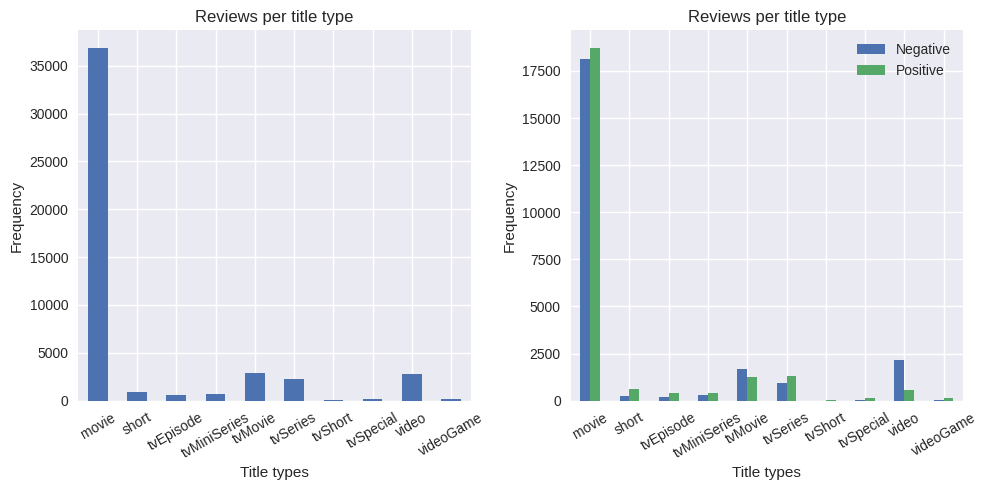

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))

ax = axs[0]
data.groupby(["title_type"])["pos"].count().plot(kind="bar",
                                       grid=True,
                                       xlabel="Title types",
                                       ylabel="Frequency",
                                       rot=30,
                                       ax=ax)
ax.set_title("Reviews per title type")

ax = axs[1]
data.groupby(["title_type", "pos"])["pos"].count().unstack().plot(kind="bar",
                                                                  grid=True,
                                                                  xlabel="Title types",
                                                                  ylabel="Frequency",
                                                                  rot=30,
                                                                  ax=ax)
ax.set_title("Reviews per title type")
ax.legend(["Negative", "Positive"])

fig.tight_layout()

In [11]:
del fig, axs

### Titles and reviews per year

Next let's see how was the movies and reviews distribution over the years. We can conclude the following from the following plots:

* The is a direct relation between the titles released and number of reviews; the more the titles released the more reviews (except a few years as in 1992 and 1994 where there were not much reviews as in other years).
* Most of the titles reviews were positive until the 90s titles.
* There are some years (like 2000, 2001, 2005 and 2006) were most of the reviews were negative.

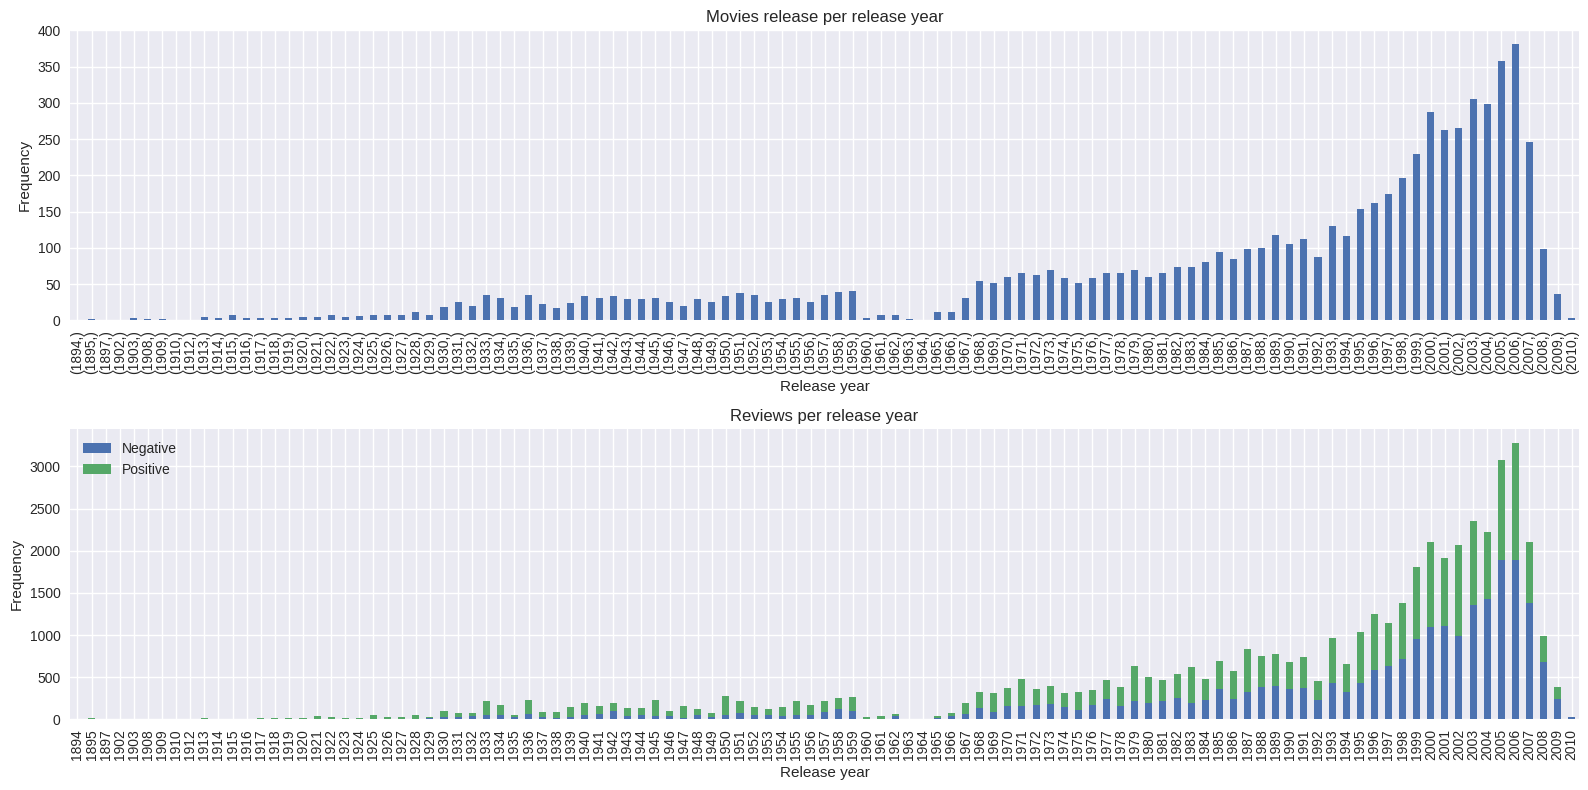

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16,8))

ax = axs[0]
df = data[["start_year", "tconst"]].drop_duplicates().drop("tconst", axis=1).value_counts().sort_index()
df.plot(kind="bar",
        grid=True,
        xlabel="Release year",
        ylabel="Frequency",
        ax=ax)
ax.set_title("Movies release per release year")

ax = axs[1]
df = data.groupby(["start_year", "pos"])["pos"].count().unstack()
df.plot(kind="bar",
        grid=True,
        xlabel="Release year",
        ylabel="Frequency",
        stacked=True,
        ax=ax)
ax.set_title("Reviews per release year")
ax.legend(["Negative", "Positive"])

fig.tight_layout()

In [13]:
del fig, axs

### Minutes, average rating and ratings distribution

In case you want to know how is distributed each title by minutes, average rating and unique ratings you can see the following histograms. We can conclude the following:

* Most of the titles have a duration of 200 minutes or less.
* Average ratings distribute mostly between 2 and somewhere between 8 and 9, and have a mean average of aproximately 6.3.
* Negative ratings spreads from 1-4 and positive ratings from 7-10. Both of them have similar behavious with top ratings their ends (1 and 10) and minimum ratings the nearest value from top one (2 and 9).

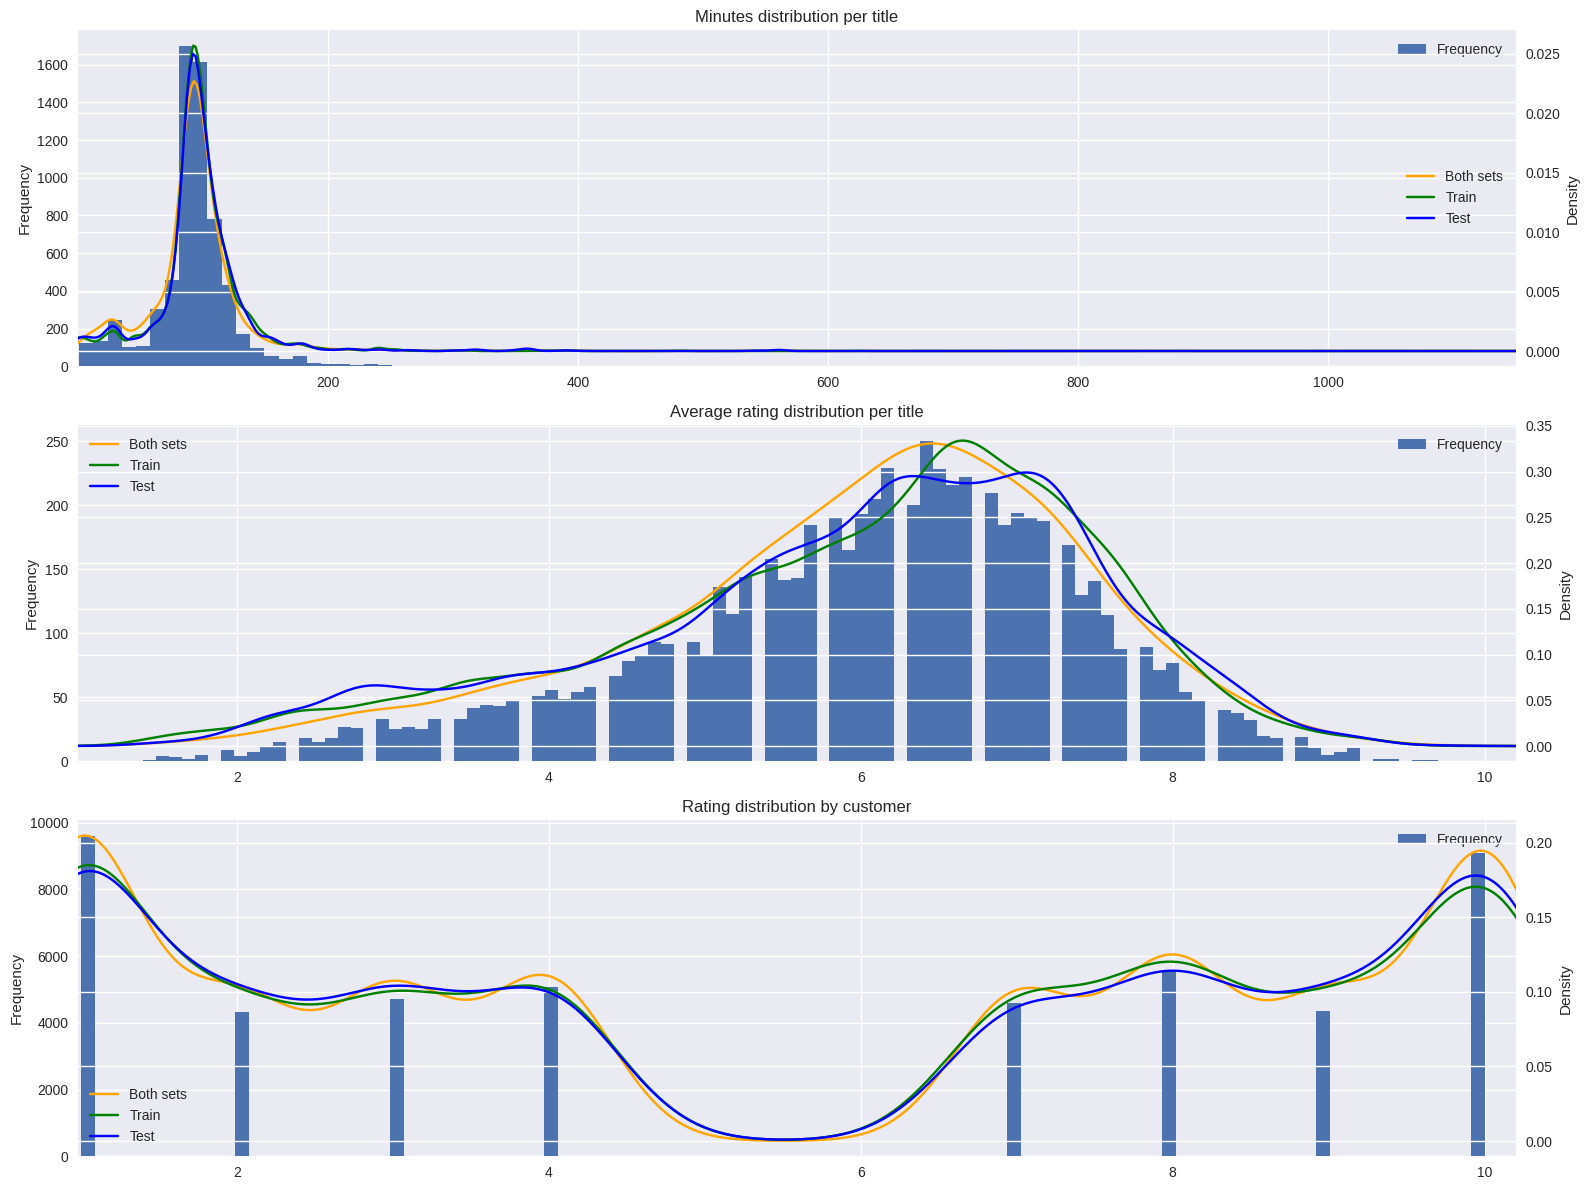

In [14]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

ax = axs[0]
df = data[data["runtime_minutes"] != 0][["tconst", "runtime_minutes"]].drop_duplicates()
df.plot(kind="hist", bins=100, ax=ax)
axt = ax.twinx()
df.plot(kind="kde", ax=axt, color="orange", xlim=(0.02, 1150))
data[data['ds_part'] == "train"][["tconst", "runtime_minutes"]].plot(kind="kde", ax=axt, color="green", xlim=(0.02, 1150))
data[data['ds_part'] == "test"][["tconst", "runtime_minutes"]].plot(kind="kde", ax=axt, color="blue", xlim=(0.02, 1150))
ax.legend(["Frequency"])
axt.legend(["Both sets", "Train", "Test"], loc="center right")
ax.set_title("Minutes distribution per title")

ax = axs[1]
df = data[data["average_rating"] != 0][["tconst", "average_rating"]].drop_duplicates()
df.plot(kind="hist", bins=100, ax=ax)
axt = ax.twinx()
df.plot(kind="kde", ax=axt, color="orange", xlim=(0.98, 10.2))
data[data['ds_part'] == "train"][["tconst", "average_rating"]].plot(kind="kde", ax=axt, color="green", xlim=(0.98, 10.2))
data[data['ds_part'] == "test"][["tconst", "average_rating"]].plot(kind="kde", ax=axt, color="blue", xlim=(0.98, 10.2))
ax.legend(["Frequency"])
axt.legend(["Both sets", "Train", "Test"], loc="upper left")
ax.set_title("Average rating distribution per title")

ax = axs[2]
df = data[["tconst", "rating"]]
df.plot(kind="hist", bins=100, stacked=True, ax=ax)
axt = ax.twinx()
df.plot(kind="kde", ax=axt, color="orange", xlim=(0.98, 10.2))
data[data['ds_part'] == "train"][["tconst", "rating"]].plot(kind="kde", ax=axt, color="green", xlim=(0.98, 10.2))
data[data['ds_part'] == "test"][["tconst", "rating"]].plot(kind="kde", ax=axt, color="blue", xlim=(0.98, 10.2))
ax.legend(["Frequency"])
axt.legend(["Both sets", "Train", "Test"])
ax.set_title("Rating distribution by customer")

fig.tight_layout()

In [15]:
del fig, axs, axt

### Pie charts

The following pie charts can help us discribe how the users and the dataset is distributed and we can conclude the following information from them:

* Almost everyone on the dataset is not an adult (99.83% not and adult and 0.17% is an adult).
* Both train and test sets have similar quantity of data (50.28% for the train set and 49.72% for the test set).
* Positive and negative reviews are distributed evenly among the train and test sets (50.10% positive reviews and 49.90% negative reviews).

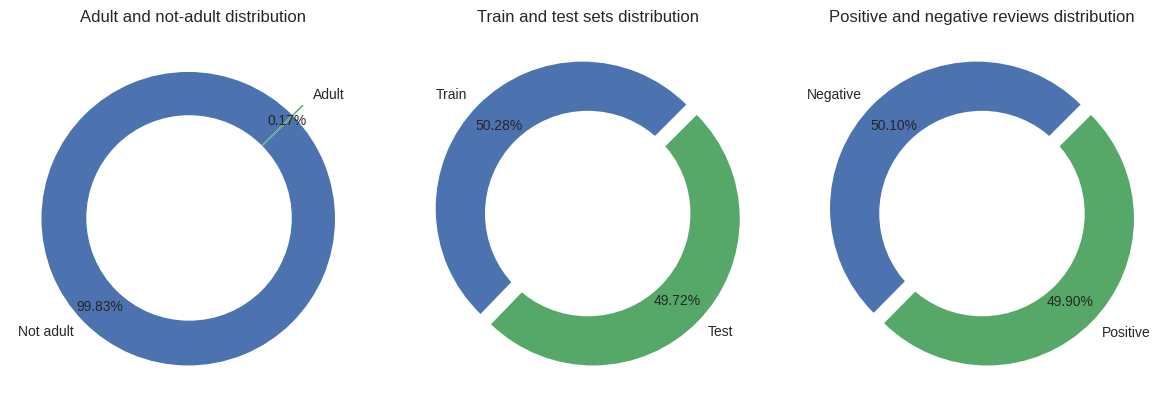

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

ax = axs[0]
labels = {0: "Not adult", 1: "Adult"}
explode = (0.05, 0.05)

df = data["is_adult"].value_counts().values
df_labels = data["is_adult"].value_counts().index

ax.pie(df, labels=df_labels.map(labels), explode=explode, pctdistance=0.85, autopct="%1.2f%%", startangle=45)
circle = plt.Circle((-0.03, -0.03), 0.7, fc="white")
ax.add_patch(circle)
ax.set_title("Adult and not-adult distribution")

ax = axs[1]
labels = {"train": "Train", "test": "Test"}
explode = (0.05, 0.05)

df = data["ds_part"].value_counts().values
df_labels = data["ds_part"].value_counts().index

ax.pie(df, labels=df_labels.map(labels), explode=explode, pctdistance=0.8, autopct="%1.2f%%", startangle=45)
circle = plt.Circle((0, 0), 0.7, fc="white")
ax.add_patch(circle)
ax.set_title("Train and test sets distribution")

ax = axs[2]
labels = {0: "Negative", 1: "Positive"}
explode = (0.05, 0.05)

df = data["pos"].value_counts().values
df_labels = data["pos"].value_counts().index

ax.pie(df, labels=df_labels.map(labels), explode=explode, pctdistance=0.8, autopct="%1.2f%%", startangle=45)
circle = plt.Circle((0, 0), 0.7, fc="white")
ax.add_patch(circle)
ax.set_title("Positive and negative reviews distribution")

fig.tight_layout()

In [17]:
del fig, axs

## Evaluation processing

Now we have a better insight of the data let's head up to train models with it and get the different classification score values from them. To make this possible we will be using the function `evaluate_model` shown below (this function was designed by TripleTen staff for our use in this project) in which we will have as inputs the following:

* `model` = The ML model we are using.
* `train_features`: Features from the train set (the train corpus).
* `train_target`: Target from the train set (0 if negative, 1 if positive).
* `test_features`: Features from the test set (the test corpus).
* `test_target`: Target from the test set (0 if negative, 1 if positive).

And the output will be:

* `F1 score plot`: F1 scores plot for the sets and model loaded.
* `ROC-AUC curve plot`: ROC-AUC curve plot for the sets and model loaded.
* `Precision-Recall curve plot`: Precision-Recall curve scores plot for the sets and model loaded.
* `df_eval_stats dataframe`: Dataframe with the scores for both train and test sets.

In [18]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    # Empty dictionary
    eval_stats = {}
    
    # Setting figure and axis dimensions
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    # Iterative process for train and test sets (this will run twice)
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        # Generating new column on dictionary
        eval_stats[type] = {}
    
        # Obatining predictions and predictions probabilities
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1 scores
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC scores
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC scores
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        # Color for plotting both sets
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 scores plot process
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # Set interest points from a few thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC curve plot process
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # Set interest points from a few thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC curve plot process
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # Set interest points from a few thresholds        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        # Adding APS and F1 scores to the dictionary
        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    # Generating a dataframe from dictionary
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    # Print dataframe
    print(df_eval_stats)
    
    return

## Normalization

Suponemos que todos los modelos a continuación aceptan textos en minúsculas y sin dígitos, signos de puntuación, etc.

For NLP (natural language processing), it is needed to process the corpus in a way the machine (computer) can interpret the information in an "easier" way. The first step in this processing is to `normalize` the corpus, this means we need to get rid of characters we do not want in further steps in the processing and can be done using regex and string processing as in the following code block.

In [19]:
pattern = r"[^a-zA-Z']"
data["review_norm"] = [re.sub(pattern, " ", row) for row in data["review"]]
data["review_norm"] = [row.split() for row in data["review_norm"]]
data["review_norm"] = [" ".join(row) for row in data["review_norm"]]
data["review_norm"] = [row.lower() for row in data["review_norm"]]

Once the processing is done we can compare the reviews before and after the processing.

In [20]:
data[["review", "review_norm"]].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i'm totally agree with garryjohal from singapo...


In [21]:
del pattern

## Train and test datasets

Now the reviews are normalized on the column `review_nom`, we can split the data in train and test sets in the variables `data_train` and `data_test`. Once here we can split easier both sets on features (corpus) and targets (score). This is the case of the variables `X_train` and `X_test` for features and `y_train` and `y_test` for targets.

In [22]:
# Training set and test set partition
data_train = data[data["ds_part"] == "train"]
data_test = data[data["ds_part"] == "test"]

# Train and test features
X_train = data_train["review_norm"]
X_test = data_test["review_norm"]

# Train and test target
y_train = data_train["pos"]
y_test = data_test["pos"]

In [23]:
del data, data_train, data_test

## Modeling

Let's head to the modeling process. The methodology for this section will be splited as following:

1. Sanity Test
2. NLTK + TF-IDF processing
    1. Logistic Regressor
    2. LGBM Classifier
    3. XGB Classifier
    
3. spaCy + TF-IDF processing
    1. Logistic Regressor
    2. LGBM Classifier
    3. XGB Classifier

For the sanity test there will be no problems on the processing stage, but when we apply the `NLTK + TF-IDF` or `spaCy + TF-IDF` processing the data among the rest of models can use more memory than we can have (this depends on the environment you are runing this notebook) so I recommend to run the following sections once at a time to avoid kernel problems:

1. Section 6.2.1
2. Section 6.2.2
3. Section 6.3.1
4. Section 6.3.2
5. Section 7.1
6. Section 7.2

### Sanity Test (Dummy Classifier)

The `Dummy Classifier` model can be used as a sanity test for a classification and we can set a state as `random_state = 0` to avoid aleatority as well as setting the parameters `strategy='constant'` and `constant='1'` (this to set the dummy model to always predict 1 constantly as the output of its predictions). As we can see, this model give us values of 0.5 for Accuracy, APS and ROC-AUC metrics, but `0.67 for F1 score` on both sets (train and test).

Those scores are far from being optimal for the project purposes, but gives us a good starting point to compare the following models (in case the new scores are worse than the sanity test scores we can be sure the model is not working correctly).

          train  test
Accuracy   0.50  0.50
F1         0.67  0.67
APS        0.50  0.50
ROC AUC    0.50  0.50


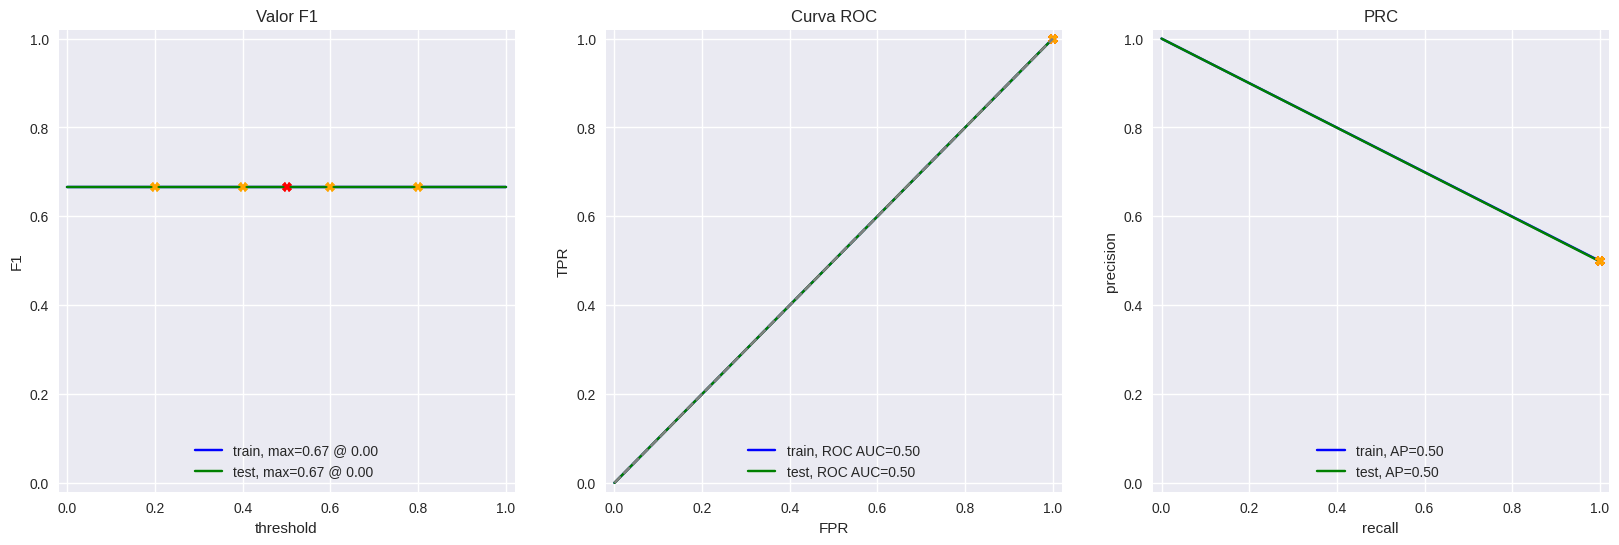

In [24]:
model = DummyClassifier(random_state=0, strategy='constant', constant=1).fit(X_train, y_train)
evaluate_model(model, X_train, y_train, X_test, y_test)

del model

### NLTK, TF-IDF

Before jump into a more complex ML model we need to finish to process the reviews on the datasets. This process commonly needs the need to tokenize and lemmatize each of the entries to reduce each of them to its "essential". This can be achieved from varios methods and one of them is the use of the NLTK library/module to apply this processing by the function `WordNetLemmatizer()`.

To make this process easier to replicate, the function `token_lemma_corpus` was designed. This function gets the corpus to transform as a input and return the same corpus with the process "tokenize + lemmatize". In other words:

1. Input:
    * `corpus`: Group of texts or words to transform.
    
2. Output:
    * `pd.Series(corpus_lemma)`: A series object with the contents of the input transformed with the "tokenize + lemmatize" process of the same lenght on the input.

In [25]:
def token_lemma_corpus(corpus):
    
    lemmatizer = WordNetLemmatizer()
    
    corpus_lemmas = []
    
    corpus_tokens = [word_tokenize(text) for text in corpus]
    
    for tokens in corpus_tokens:
        lemmas = [lemmatizer.lemmatize(token) for token in tokens]
        lemmas = " ".join(lemmas)
        corpus_lemmas.append(lemmas)
        
    return pd.Series(corpus_lemmas)

#### ngram_range = None

Using the function `token_lemma_corpus` we can transform the corpi `X_train` and `X_test` and generate the new corpi `corpus_train` and `corpus_test`. Then using the NLTK function `TfidfVectorizer` we can obtain a new corpi `tf_idf_train` and `tf_idf_test` which are two series object variables with a list of vectorized reviews (a bag of words).

The models that will be used this sections are:
1. Logistic Regressor
2. LGBMClassifier
3. XGBClassifier

`CatBoostClassifier` will not be used because it was not found a way to apply it without kernel problems.

Also `BERT` processing will not be used due to its high resources consuming capacity.

In [68]:
corpus_train = token_lemma_corpus(X_train)
corpus_test = token_lemma_corpus(X_test)

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

del corpus_train, corpus_test, stop_words, count_tf_idf

# Can't be used, kernel dies
#model = CatBoostClassifier(random_state=0).fit(tf_idf_train, y_train)

##### Logistic Regressor

The first ML model we are going to test is the Logistic Regressor model. This model gives a `F1 score of 0.88` for the test set (0.03 units above the required), so we can conclude we can use this model for this specific application. Down are the scores and plots referring to the F1 scores, ROC-AUC curve and PRC curve for the training and test set.


To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.1.1`. Do not uncomment the code in the following code block.

          train  test
Accuracy   0.94  0.88
F1         0.94  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


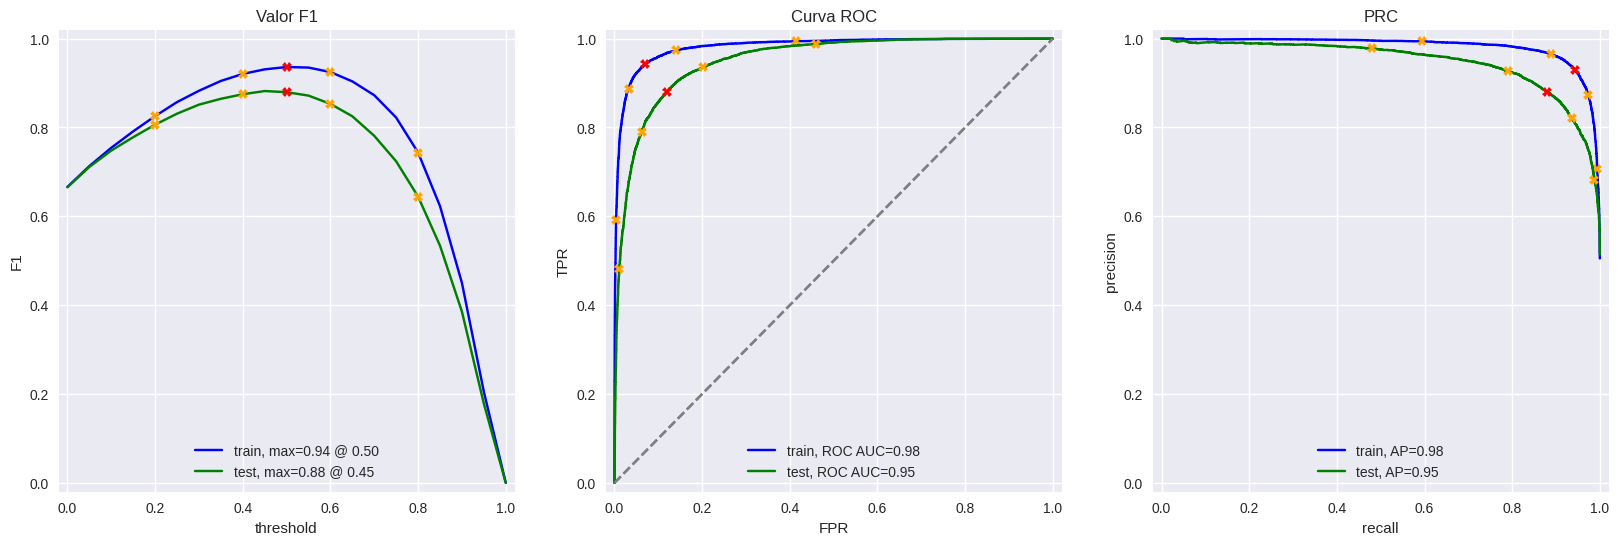

In [69]:
model = LogisticRegression(random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del model

##### LGBMClassifier

LGBMClassifier is a more complex linear regression model than Logistric Regressor that uses gradient boosting as part of the model. For this model we obtain a `F1 score of 0.85` for the test set (just the minimum required). Is probable this score (and the others in the table below) can increase with a different paramenter configuration for the model, but due to the limitations on memory within the server more complex configurations cannot be done in this environment.


To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.1.2`. Do not uncomment the code in the following code block.

          train  test
Accuracy   0.92  0.84
F1         0.92  0.85
APS        0.98  0.92
ROC AUC    0.98  0.93


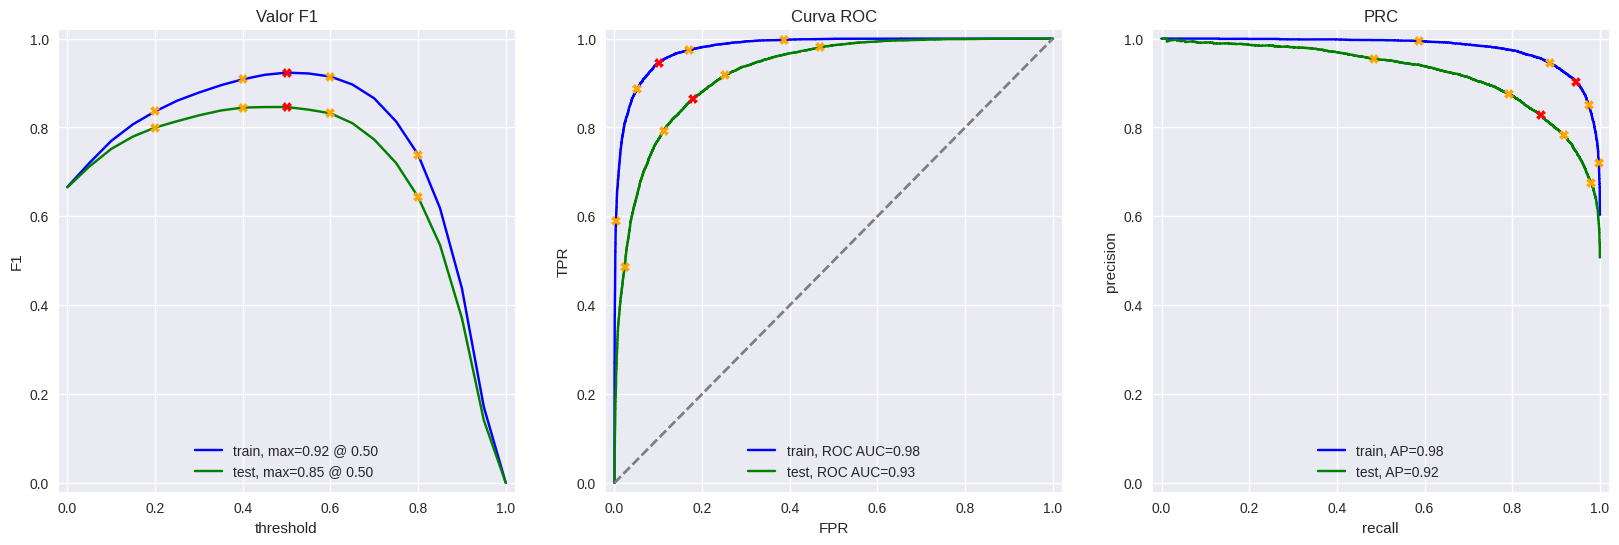

In [33]:
model = lgb.LGBMClassifier(learning_rate=0.1, boosting_type="gbdt", objective="binary", num_leaves=50, max_depth=10, n_jobs=50, random_state=0)
model.fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del model

##### XGBClassifier

XGBClassifier is a gradient boosting model quite similar to LGBMClassifier, but with the difference the first one is an ensemble of tree classifier models. The F1 score obtained for this model is 0.85 (the same as in LGBMClassifier). Same as in LGBMClassifier, is probable this score can be improved with a different parameters configuration, but due to the servers limitation it cannot be done in this environment.


To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.1.3`. Do not uncomment the code in the following code block.

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:11:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.99  0.85
F1         0.99  0.85
APS        1.00  0.93
ROC AUC    1.00  0.93


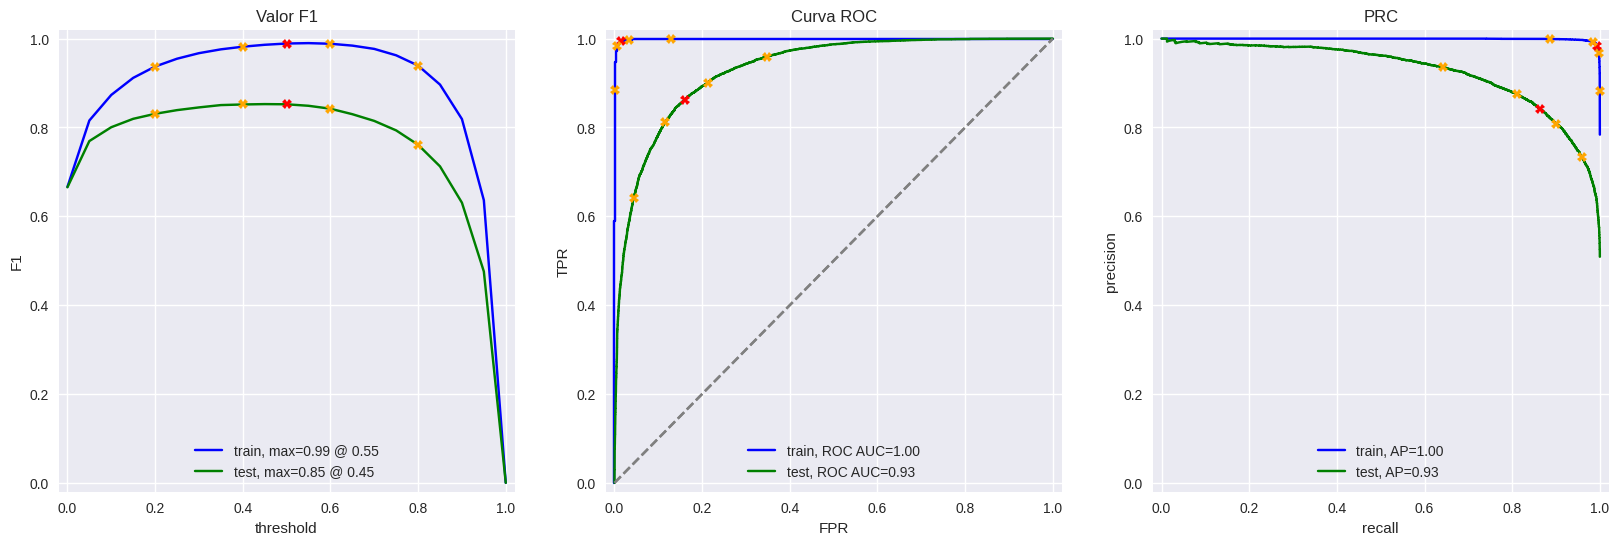

In [34]:
model = xgb.XGBClassifier(booster="dart", objective="binary:logistic", max_leaves=50, max_depth=10, n_jobs=50, random_state=0)
model.fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del tf_idf_train, tf_idf_test, model

#### ngrams_range = (2, 2)

Same as in the corpus processing on section 6.2.1, we can vectorize the corpus we have using `ngrams`. This can be set in the parameter `ngrams_range` within function `TfidfVectorizer` and if we want to set obly ngrams of lenght 2 the input shall be `ngrams_range = (2, 2)` (in our case, we set this configuration through variables `min_n` and `max_n`). This will return vectorized texts with a ngram configuration.

----------------------------------------------------------------------------------------------------------------------------

`DISCLAIMER`

This section was set as comments alone because the processing time with ngrams is quite higher than with standard vectorization and this configuration does not improve the scores obtained compared with models on section 6.2.1, and due to memory problems, more complex models configurations cannot be done. If you want to run code blocks on this section (section 6.2.2) I recommend you run them alone and do not run any other models code blocks to avoid the kernel to stop working.

In [11]:
'''corpus_train = token_lemma_corpus(X_train)
corpus_test = token_lemma_corpus(X_test)

min_n = 2
max_n = 2

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(min_n, max_n))
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

del corpus_train, corpus_test, min_n, max_n, stop_words, count_tf_idf'''

##### Logistic Regressor

This models gives us a `F1 score of 0.84` (0.01 units below the minimum required) so this may indicate the using of ngrams with this models could not be the best option for the solution.

          train  test
Accuracy   0.99  0.84
F1         0.99  0.84
APS        1.00  0.92
ROC AUC    1.00  0.92


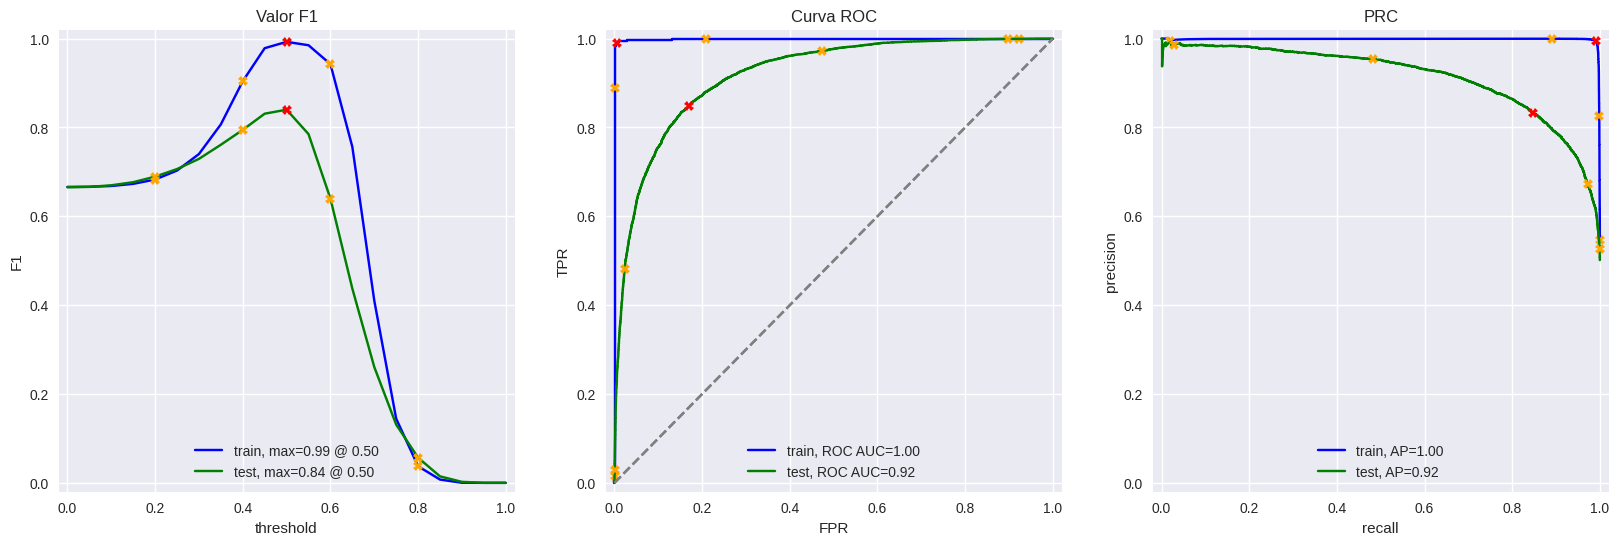

In [13]:
'''model = LogisticRegression(random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del model'''

##### LGBMClassifier

This models has a `F1 score of 0.80` (0.05 units below the minimum required) so this model cannot be used as the final model. Due to memory issues some parameters cannot be set, so this model cannot be improved in the actual environment.

          train  test
Accuracy   0.84  0.79
F1         0.85  0.80
APS        0.92  0.87
ROC AUC    0.93  0.88


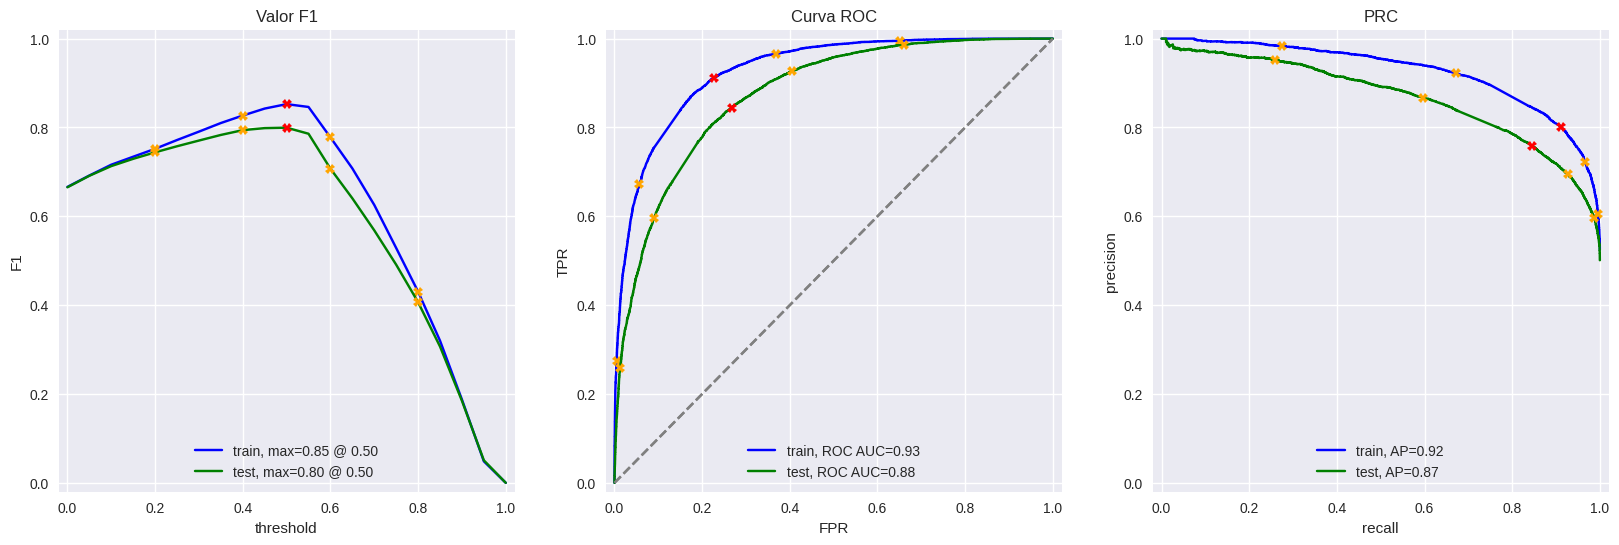

In [14]:
'''model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del model'''

##### XGBClassifier

This model has a `F1 score of 0.78` (0.07 units below the minimum required) so this model and vectorization should not be used as the final model. Due to the same reasons as in section 6.2.2.2, this model cannot be improved in the current environment.

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:37:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.83  0.76
F1         0.84  0.78
APS        0.90  0.84
ROC AUC    0.91  0.85


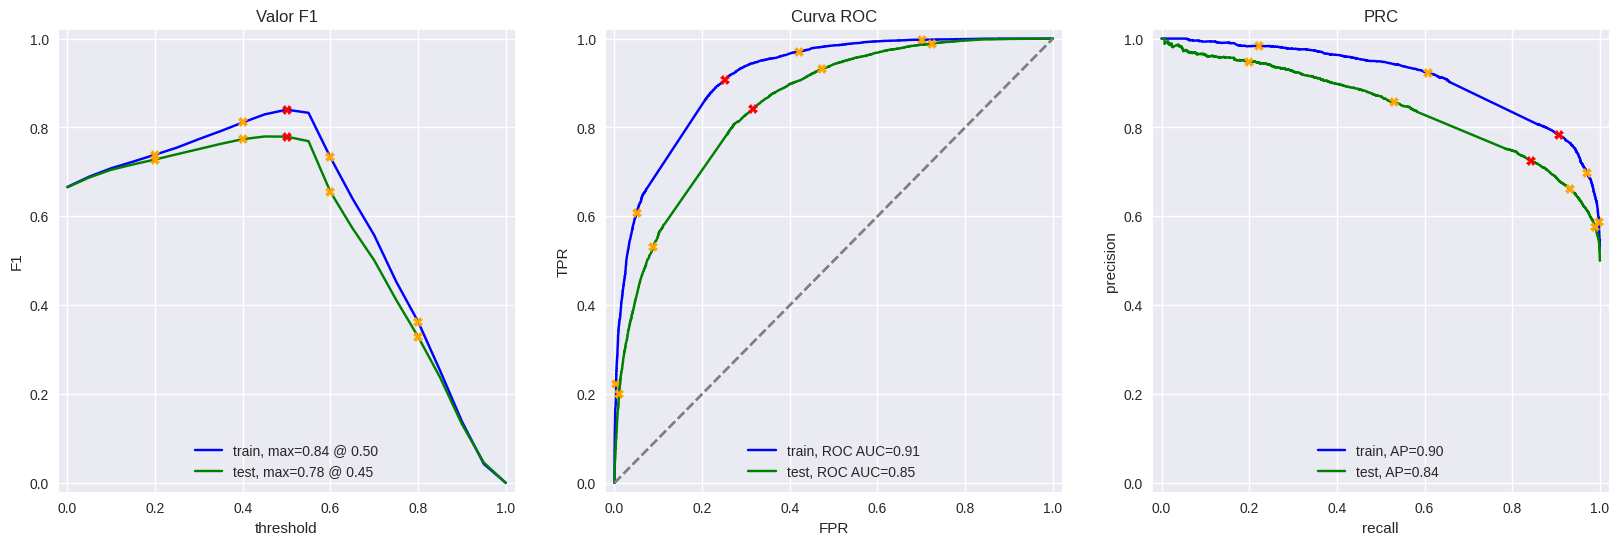

In [12]:
'''model = xgb.XGBClassifier(booster="dart", objective="binary:logistic", random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del tf_idf_train, tf_idf_test, model'''

### spaCy, TF-IDF

Similar to the NLTK module exists the library/module `spaCy`. This module works the same way as in NLTK, but with is own class `spacy` and using the function `load` we can load the english language configuration. Once this we can tokenize all texts in the corpus using the objects in which we load the spacy model (`nlp` in our case) and then lemmanize each token on each tokenized text. All this is encapsulated in the function `spacy_lemma`.

In [80]:
def spacy_lemma(corpus):
    
    lemmas = []
    nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
    
    for row in corpus:
        
        tokens = nlp(row)
        lemma = [token.lemma_ for token in tokens]
        lemma = " ".join(lemma)
        lemmas.append(lemma)
        
    return lemmas

#### ngram_range = None

Using the function `spacy_lemma` we can transform the corpi `X_train` and `X_test` and generate the new corpi `corpus_train` and `corpus_test`. Then using the NLTK function `TfidfVectorizer` we can obtain a new corpi `tf_idf_train` and `tf_idf_test` which are two series object variables with a list of vectorized reviews (a bag of words).

The models that will be used this sections are:
1. Logistic Regressor
2. LGBMClassifier
3. XGBClassifier

`CatBoostClassifier` will not be used because it was not found a way to apply it without kernel problems.

In [81]:
corpus_train = spacy_lemma(X_train)
corpus_test = spacy_lemma(X_test)

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

del count_tf_idf, corpus_train, corpus_test, stop_words

##### Logistic Regressor

This models has a `F1 score of 0.88` (0.08 units above the minimum required) so this model can be used as the final model. Let's compare this values with other models scores and test if this the best option available.

To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.2.1`. Do not uncomment the code in the following code block.

          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


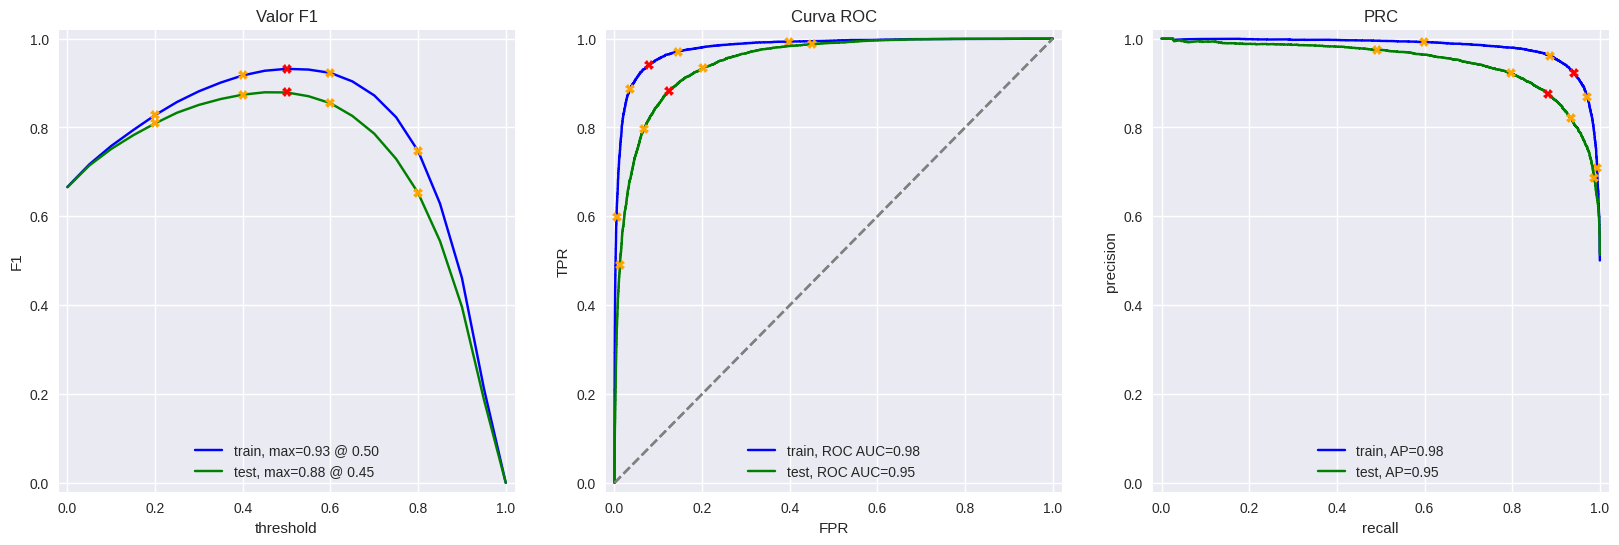

In [82]:
model = LogisticRegression(random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del model

##### LGBMClassifier

This models has a `F1 score of 0.85` (the minimum required score) so this model can be used as the final model. Let's test if there are better options for the final model.

To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.2.2`. Do not uncomment the code in the following code block.

          train  test
Accuracy   0.92  0.84
F1         0.92  0.85
APS        0.98  0.92
ROC AUC    0.98  0.92


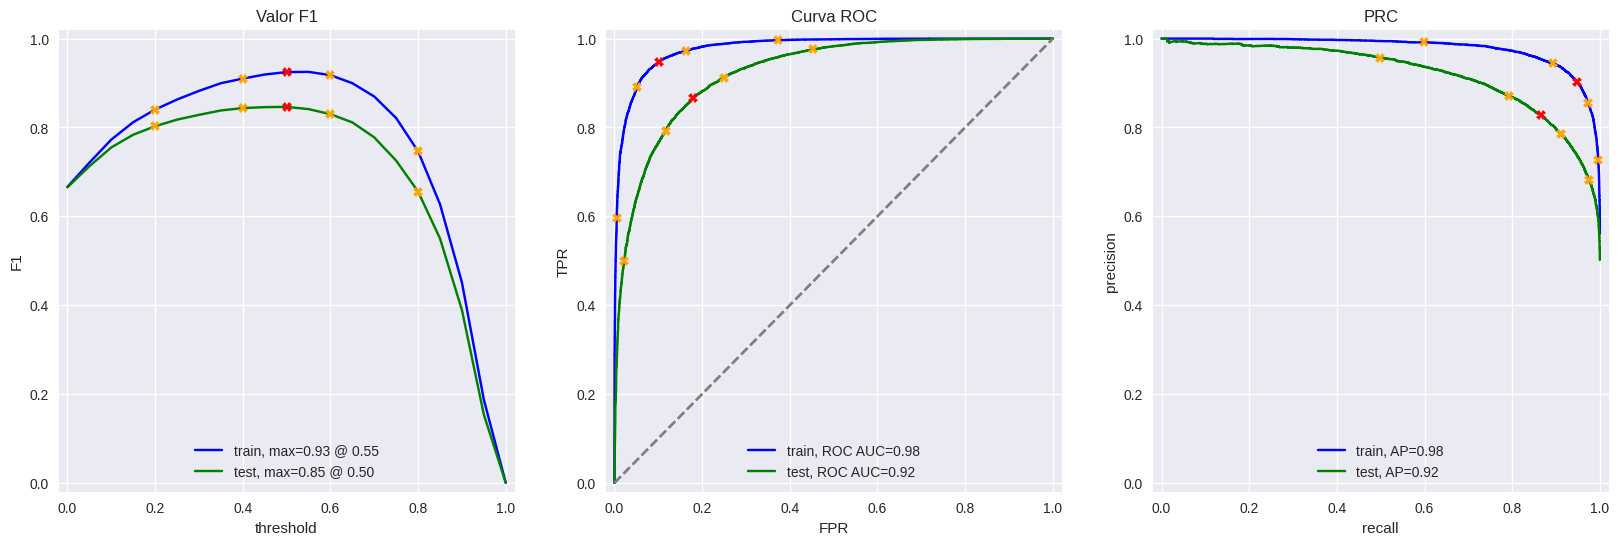

In [87]:
model = lgb.LGBMClassifier(learning_rate=0.1, boosting_type="gbdt", objective="binary", num_leaves=50, max_depth=10, n_jobs=50, random_state=0)
model.fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del model

##### XGBClassifier

This models has a `F1 score of 0.85` the same as the last model) so this model can be used as the final model.

To see the predictions for a new set of reviews and comparing results for this specific configuration go to `section 7.2.3`. Do not uncomment the code in the following code block.

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:35:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.99  0.85
F1         0.99  0.85
APS        1.00  0.93
ROC AUC    1.00  0.93


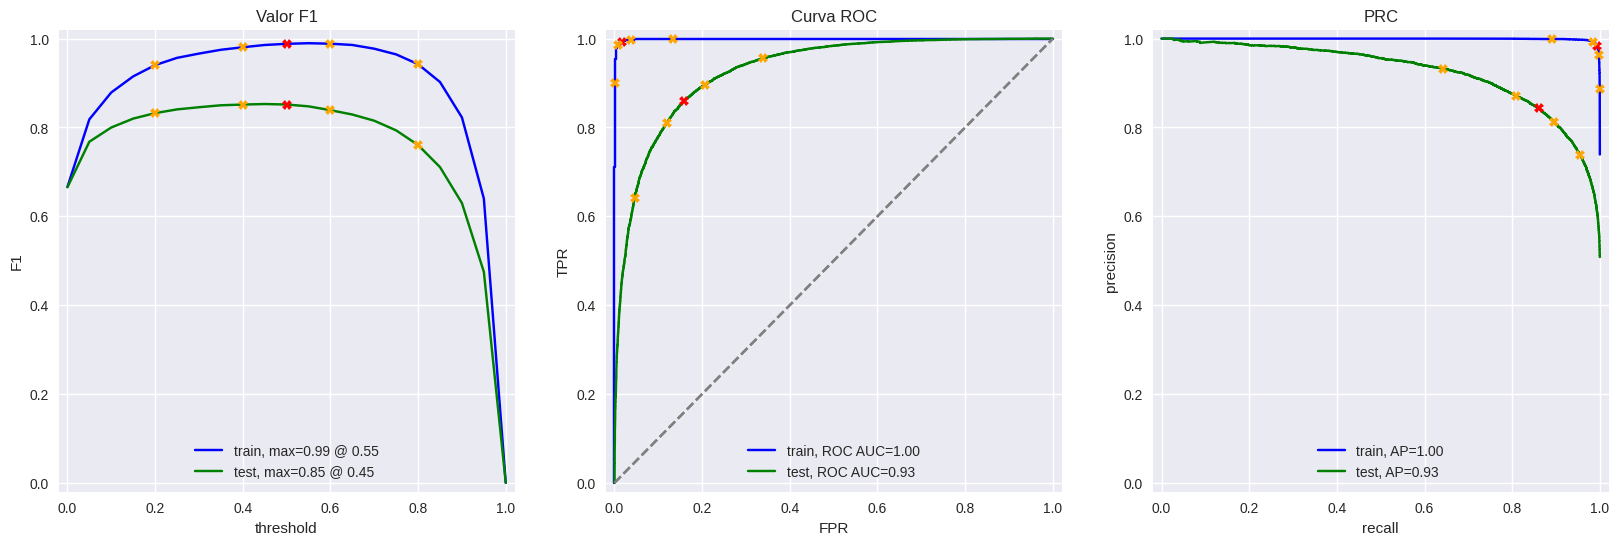

In [91]:
model = xgb.XGBClassifier(booster="dart", objective="binary:logistic", max_leaves=50, max_depth=10, n_jobs=50, random_state=0)
model.fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

#del tf_idf_train, tf_idf_test, model

#### ngrams_range = (2, 2)

Similar to section 6.2.2, we can apply a ngram process to the TfidfVectorizer using its parameter `ngram_range` as (2, 2) to the corpus processed with the module `spaCy`.

In [11]:
'''corpus_train = spacy_lemma(X_train)
corpus_test = spacy_lemma(X_test)

min_n = 2
max_n = 2

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words, ngram_range=(min_n, max_n))
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test = count_tf_idf.transform(corpus_test)

del corpus_train, corpus_test, min_n, max_n, stop_words, count_tf_idf'''

##### Logistic Regressor

This models has a `F1 score of 0.84` (same score as in section 6.2.2.1) so this model cannot be used as the final model. Due to memory issues some parameters cannot be set, so this model cannot be improved in the actual environment.

          train  test
Accuracy   0.99  0.84
F1         0.99  0.84
APS        1.00  0.91
ROC AUC    1.00  0.92


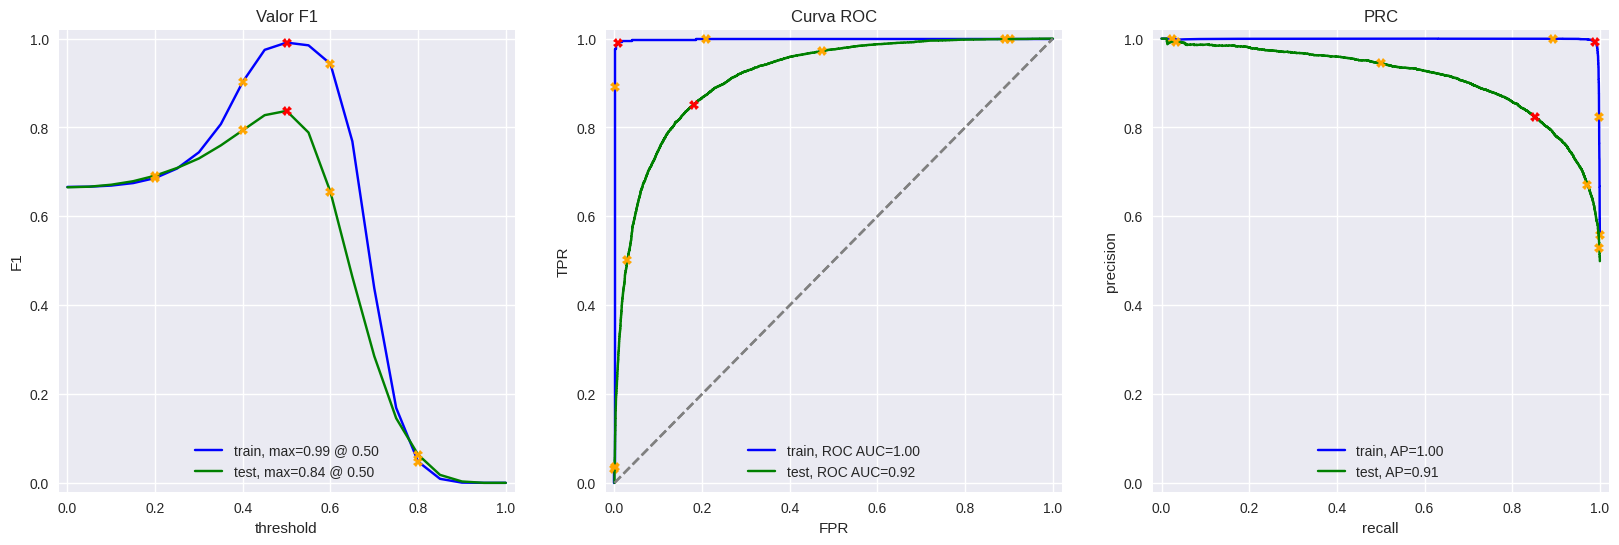

In [31]:
'''model = LogisticRegression(random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del model'''

##### LGBMClassifier

This models has a `F1 score of 0.79` (0.06 units below the minimum required and worse than model on section 6.2.2.2) so this model cannot be used as the final model. Due to memory issues some parameters cannot be set, so this model cannot be improved in the actual environment.

          train  test
Accuracy   0.84  0.78
F1         0.85  0.79
APS        0.92  0.86
ROC AUC    0.93  0.87


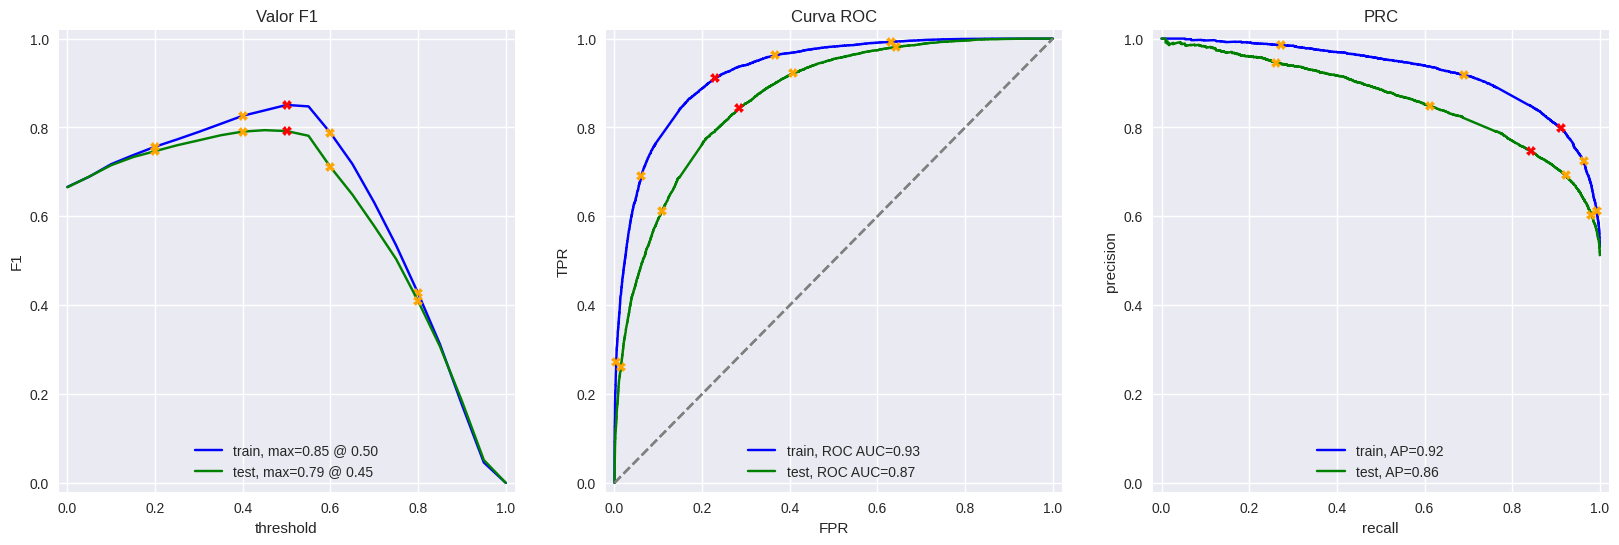

In [32]:
'''model = lgb.LGBMClassifier(boosting_type="gbdt", objective="binary", random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del model'''

##### XGBClassifier

This models has a `F1 score of 0.78` (0.07 units below the minimum required and the same as the model on section 6.2.2.3) so this model cannot be used as the final model. Due to memory issues some parameters cannot be set, so this model cannot be improved in the actual environment.

/opt/conda/envs/python3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:36:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
          train  test
Accuracy   0.82  0.76
F1         0.84  0.78
APS        0.90  0.83
ROC AUC    0.91  0.84


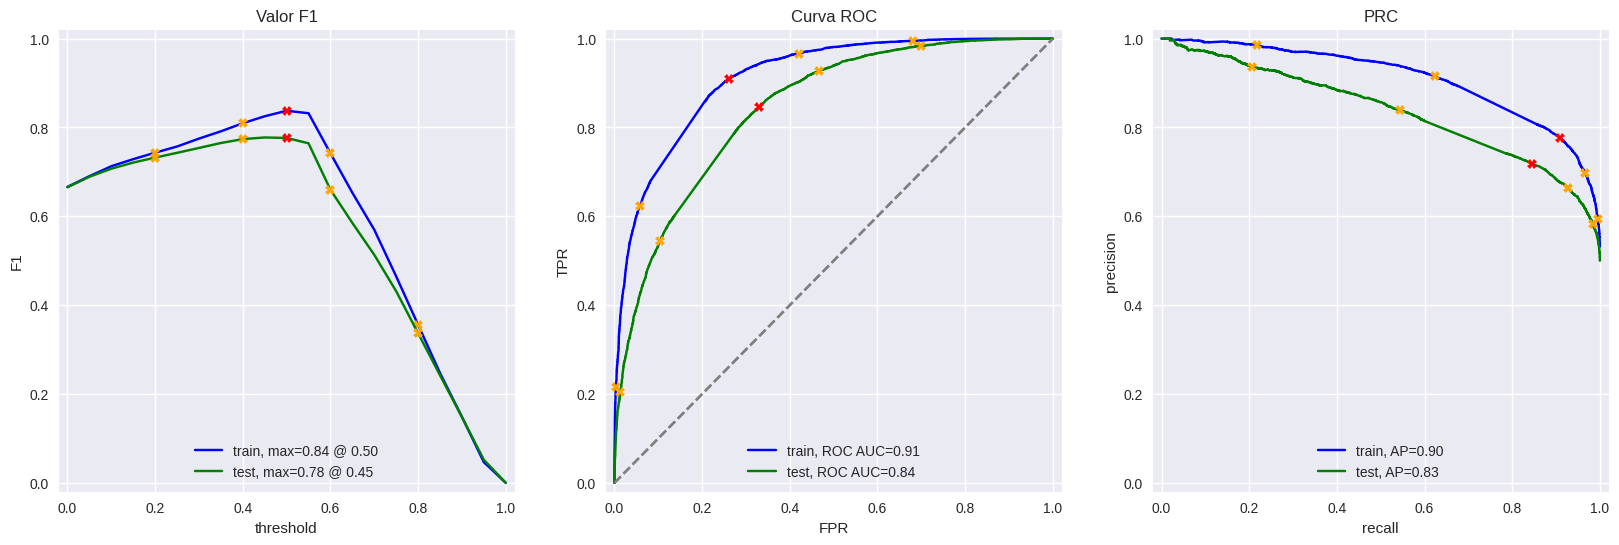

In [12]:
'''model = xgb.XGBClassifier(booster="dart", objective="binary:logistic", random_state=0).fit(tf_idf_train, y_train)
evaluate_model(model, tf_idf_train, y_train, tf_idf_test, y_test)

del tf_idf_train, tf_idf_test, model'''

### Results

Down below we can see in tables the results for all the models tested on section 6. It is interesting to see only the models with the parameter `ngram_range = None` have F1 scores more or equal than the minimum score required (0.85). This may imply using the function `TfidfVectorizer` may be more useful out of a ngram processing. Also, it can be seen the corpi with the NLTK processing have better F1 scores than the corpi with the spaCy processing. This may also mean the NLTK processing have better results than the spaCy processing for the current information, but we should not generalize this for all the information.

The information on the cells within each table is accomodated as the following: `(train set / test set)`.

1. NLTK:

* Logistic Regressor:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.94 / 0.88 | 0.99 / 0.84 |
| F1 | 0.94 / 0.88 | 0.99 / 0.84 |
| APS | 0.98 / 0.95 | 1.00 / 0.92 |
| ROC AUC | 0.98 / 0.95 | 1.00 / 0.92 |

* LGBMClassifier:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.92 / 0.84 | 0.84 / 0.79 |
| F1 | 0.92 / 0.85 | 0.85 / 0.80 |
| APS | 0.98 / 0.92 | 0.92 / 0.87 |
| ROC AUC | 0.98 / 0.93 | 0.93 / 0.88 |

* XGBClassifier:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.99 / 0.85 | 0.83 / 0.76 |
| F1 | 0.99 / 0.85 | 0.84 / 0.78 |
| APS | 1.00 / 0.93 | 0.90 / 0.84 |
| ROC AUC | 1.00 / 0.93 | 0.91 / 0.85 |

2. spaCy:

* Logistic Regressor:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.93 / 0.88 | 0.99 / 0.84 |
| F1 | 0.93 / 0.88 | 0.99 / 0.84 |
| APS | 0.98 / 0.95 | 1.00 / 0.91 |
| ROC AUC | 0.98 / 0.95 | 1.00 / 0.92 |

* LGBMClassifier:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.92 / 0.84 | 0.84 / 0.78 |
| F1 | 0.92 / 0.85 | 0.85 / 0.79 |
| APS | 0.98 / 0.92 | 0.92 / 0.86 |
| ROC AUC | 0.98 / 0.92 | 0.93 / 0.87 |

* XGBClassifier:

|  | ngram_range = None | ngram_range = (2, 2) |
|----|----|----|
| Accuracy | 0.99 / 0.85 | 0.82 / 0.76 |
| F1 | 0.99 / 0.85 | 0.84 / 0.78 |
| APS | 1.00 / 0.93 | 0.90 / 0.83 |
| ROC AUC | 1.00 / 0.93 | 0.91 / 0.84 |

### Conclusions

1. It is necessary to pre-processing the corpus in a corresponding way to continue to the modeling processing. Regex + NLTK or spaCy are options we can use to transform corpi, and depending on the case you would want to use an ngram vectorization process.

2. It is recommended to test different processing strategies to assure to select the best option available for the application required on every task.

3. Using more complex machine learning models can improve the results with the same information, but you need to be aware of the limitations of your own resources and determine whether or not use a specific model or not.

## Improvised reviews

An interesting point to test our models with is with new reviews. This will be a similar process to the one done on the test set, but we have to clarify that due to the low quantity of "improvised reviews" on this section the incoming results are spected to be lower than the ones obtained in section  6.1 and 6.2.

All models within this sections will work with corpi vectorized with a configuration of `ngrams_range = None` because it was determined that configuration was the best fitting for the current memory available and the one with better results returned.

In [59]:
# New reviews
reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

# Regex processing
pattern = r"[^a-zA-Z']"
reviews["review_norm"] = [re.sub(pattern, " ", row) for row in reviews["review"]]
reviews["review_norm"] = [row.split() for row in reviews["review_norm"]]
reviews["review_norm"] = [" ".join(row) for row in reviews["review_norm"]]
reviews["review_norm"] = [row.lower() for row in reviews["review_norm"]]

# Sentiment test results for each review
reviews["pos"] = [0, 0, 1, 0, 1, 1, 0, 1]

### NLTK, TF-IDF

Applying the same processing as in section 6.2 we can obtain the corpi for the train set and the improvised reviews set.

In [70]:
corpus_train = token_lemma_corpus(X_train)
corpus_test = token_lemma_corpus(reviews["review_norm"])

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test_imp = count_tf_idf.transform(corpus_test)

del corpus_train, corpus_test, stop_words, count_tf_idf

#### Logistic Regressor

This models has a `F1 score of 0.67` (same ass the dummy model). Being the model with worst results in models within this section, we can be sure we would not want to use this model for smaller datasets.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [71]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [75]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.67.

0 (0.16): i did not simply like it not my kind of movie
0 (0.14): well i was bored and felt asleep in the middle of the movie
0 (0.46): i was really fascinated with the movie
0 (0.12): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0 (0.30): i didn't expect the reboot to be so good writers really cared about the source material
1 (0.53): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.04): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.87): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


#### LGBMClassifier

This models has a `F1 score of 0.73` (0.12 units below the minimum required). With 0.02 units below the highest score achieved in model within this section, the F1 score is pretty decent, but we need a higher score.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [77]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [79]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.73.

1 (0.62): i did not simply like it not my kind of movie
1 (0.59): well i was bored and felt asleep in the middle of the movie
1 (0.58): i was really fascinated with the movie
1 (0.52): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
1 (0.64): i didn't expect the reboot to be so good writers really cared about the source material
1 (0.60): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.35): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.62): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


#### XGBClassifier

This models has a `F1 score of 0.75` (0.10 units below the minimum requires). This model returns the highest F1 score among the 3 models tested with a probability of 3 in 4 to predict correctly the sentiment test of the new reviews.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [62]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [66]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.75.

1 (0.60): i did not simply like it not my kind of movie
0 (0.47): well i was bored and felt asleep in the middle of the movie
1 (0.55): i was really fascinated with the movie
0 (0.34): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0 (0.38): i didn't expect the reboot to be so good writers really cared about the source material
1 (0.57): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.27): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.62): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


### spaCy, TF-IDF

Applying the same processing as in section 6.3 we can obtain the corpi for the train set and the improvised reviews set.

In [83]:
corpus_train = spacy_lemma(X_train)
corpus_test = spacy_lemma(reviews["review_norm"])

stop_words = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
tf_idf_test_imp = count_tf_idf.transform(corpus_test)

del count_tf_idf, corpus_train, corpus_test, stop_words

#### Logistic Regressor

This models has a `F1 score of 0.40` (0.27 units below the dummy model F1 score). Due to this be the lowest result returned in this section, we conclude this model and the spaCy processing should not be used as an optimal prediction model.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [84]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [86]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.40.

0 (0.20): i did not simply like it not my kind of movie
0 (0.12): well i was bored and felt asleep in the middle of the movie
0 (0.49): i was really fascinated with the movie
0 (0.10): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0 (0.27): i didn't expect the reboot to be so good writers really cared about the source material
0 (0.50): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.03): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.92): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


#### LGBMClassifier

This models has a `F1 score of 0.80` (0.05 units below the minimum required). This result is quite impressive considering the low amount of reviews for the test set. This may be the best model we could use for lower dataset because this result states the model can predict almost 4 reviews in 5 correctly.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [88]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [90]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.80.

1 (0.62): i did not simply like it not my kind of movie
0 (0.46): well i was bored and felt asleep in the middle of the movie
1 (0.62): i was really fascinated with the movie
1 (0.52): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
1 (0.68): i didn't expect the reboot to be so good writers really cared about the source material
1 (0.67): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.41): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.74): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


#### XGBClassifier

This models has a `F1 score of 0.75` (0.10 units below the minimum required). The result, and the reason why this is not higher considering the previous result, can be due to the overfitting that is common in this model. This may be stating that, even this model has a lower F1 score compared to the previous model (LGBMClassifier), we shall consider to work with this model for lower datasets.

The format of the results will be presented as following: `"prediction (prediction probability): normalized review"`.

In [92]:
preds = model.predict(tf_idf_test_imp)
preds_probs = model.predict_proba(tf_idf_test_imp)

In [93]:
print(f"F1 score: {metrics.f1_score(reviews['pos'], preds):.2f}.\n")

for index in range(0, len(reviews["pos"])):
    print(f"{preds[index]} ({preds_probs[index, 1]:.2f}): {reviews['review_norm'][index]}")
    
#del model, preds, preds_probs

F1 score: 0.75.

1 (0.64): i did not simply like it not my kind of movie
0 (0.39): well i was bored and felt asleep in the middle of the movie
1 (0.61): i was really fascinated with the movie
0 (0.37): even the actors looked really old and disinterested and they got paid to be in the movie what a soulless cash grab
0 (0.34): i didn't expect the reboot to be so good writers really cared about the source material
1 (0.84): the movie had its upsides and downsides but i feel like overall it's a decent flick i could see myself going to see it again
0 (0.39): what a rotten attempt at a comedy not a single joke lands everyone acts annoying and loud even kids won't like this
1 (0.82): launching on netflix was a brave move i really appreciate being able to binge on episode after episode of this exciting intelligent new drama


### Results

The results from the models in this sections are showed below. In the same way as in section 6.4, the numbers are splitted in `(train set / test set)`.

* NLTK + TF-IDF

|  | Logistic Regressor | LGBMClassifier | XGBClassifier |
|----|----|----|----|
| Accuracy | 0.94 / 0.75 | 0.92 / 0.62 | 0.99 / 0.75 |
| F1 | 0.94 / 0.67 | 0.92 / 0.73 | 0.99 / 0.75 |
| APS | 0.98 / 1.00 | 0.98 / 0.77 | 1.00 / 0.77 |
| ROC AUC | 0.98 / 1.00 | 0.98 / 0.75 | 1.00 / 0.75 |

* spaCy + TF-IDF

|  | Logistic Regressor | LGBMClassifier | XGBClassifier |
|----|----|----|----|
| Accuracy | 0.93 / 0.62 | 0.92 / 0.75 | 0.99 / 0.75 |
| F1 | 0.93 / 0.40 | 0.92 / 0.80 | 0.99 / 0.75 |
| APS | 0.98 / 1.00 | 0.98 / 0.95 | 1.00 / 0.81 |
| ROC AUC | 0.98 / 1.00 | 0.98 / 0.97 | 1.00 / 0.69 |

### Conclusions

It is important to remember that when you have a low amount of information for either the train or test set you will probably have lower results on different metrics because the underfitting the information can bring to the model. Either way, depending on the model you want to test in the data you can obtain results that can be enough for the current task, but this depend in various points that shall be taken into consideration (as how the data in distributed, model used and/or parameters of the model). We shall test different options before conclude the use of a specific model is the best for the current task.

## General conclusions

1. The first thing we shall to determine before start a natural language processing is to decide which modules to transform the corpus we will be using to amke this possible. As stated before, NLTK and spaCy + regex processing can help us in this application, but there can be better options for an specific task.

2. The NLP (natural language processing) is a task that is high resource consuming, sometimes making it difficult to apply depending the environment in which we are intending to make this.

3. Tetsting different models and/or corpi processing methods is fundamental at the momento to develop a NLP model. This is because depending on the information we have (commonly you will not have the complete insight of the data before working on it) different methods will return different results we might skip if only use one model.